In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
author_data = pd.read_csv("../data/raw/author_data.csv")
comment_data = pd.read_csv("../data/raw/comment_data.csv")
gilds_data = pd.read_csv("../data/raw/gildings_data.csv")
threads_data = pd.read_csv("../data/raw/thread_data.csv")

/home/jeevan/.local/share/virtualenvs/Programming-Files-01Pl4DQl/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,3,4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Remove the duplicates - I had to run a modified version of the script since desktop kept shutting down (due to inclement weather; used append flag as a quick fix which resulted in all of the data being written multiple times).

In [3]:
def drop_duplicates_na(data, key_columns):
    '''Takes in data and key columns as parameters, in this case, key column refers to
    the columns to consider for identifying duplicates. Returns a dataframe where the 
    duplicates (all except for the last occurrence) and columns with NA are removed.'''
    df = data.copy()
    df.drop_duplicates(subset=key_columns, keep='last', inplace=True, ignore_index=True)
    return df.dropna()

In [4]:
authors_data = drop_duplicates_na(author_data, ['author_ids'])
comments_data = drop_duplicates_na(comment_data, ['comment_ids'])
gilds_data = drop_duplicates_na(gilds_data, ['comment_ids'])
threads_data = drop_duplicates_na(threads_data, ['thread_ids'])

In [5]:
from pathlib import Path

def save(df, savepath, filename):
    '''Takes in a dataframe and a filename for saving to csv'''
    Path(savepath).mkdir(parents=True, exist_ok=True) #Make the folder if it already doesn't exist
    df.to_csv(f"{savepath}{filename}.csv", index=False)

save(authors_data, "../data/interim/", "author_data")
save(comments_data, "../data/interim/", "comment_data")
save(gilds_data, "../data/interim/", "gildings_data")
save(threads_data, "../data/interim/", "threads_data")

In [6]:
from datetime import timedelta
import time

def toDays(x, currentime):
    '''Takes in created_utc time (Unix time, in seconds) and current time. Calculates
    age and returns the number of days'''
    d = timedelta(seconds=currentime-x)
    return d.days

def process_dates(data, new_column):
    '''Convert the created_utc time to datetime, fetch the days and place it
    in a new column. Also removes the original created_utc column'''
    df = data.copy()
    now = time.time() #This will differ everytime, but the change will be constant across all the rows.
    df[new_column] = df.created_utc.map(lambda x: toDays(x, now))
    return df.drop(["created_utc"], axis=1)
    
authors = process_dates(authors_data, "acc_age_days")
comments = process_dates(comments_data, "comment_age_days")

For a baseline model, we will work with binary classification (whether a comment is gilded or not). For that, we need to do slightly different transformations, and since there's a large imbalance (gilded vs not gilded comments), we will have to transform the full data and then use stratified sampling.

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class gilds_binary(BaseEstimator, TransformerMixin):
    '''Using Sklearn's base transformer class to process the gildings column (convert the dictionary into binary)'''
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df["gildings"].fillna(0, inplace=True)
        df["gildings"] = df["gildings"].apply(lambda x: 1 if x != 0 else 0)
        return df

In [43]:
comment_gilds = gilds_data.merge(comments, how='outer', on='comment_ids')
comments_all = comment_gilds.merge(authors, how='inner', on='author_ids')

transform_gilds = gilds_binary()
comments_all, targets = transform_gilds.transform(comments_all)
all_data = comments_all #.filter(items=["ups", "comment_karma", "link_karma", "is_premium", "comment_age_days", "acc_age_days"], axis=1)

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splits.split(all_data, targets):
    pass
train_data = all_data.iloc[train_index, :]
test_data = all_data.iloc[test_index, :]

In [47]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
save(train_data, "../data/processed/", "train_data_baseline")
save(test_data, "../data/processed/", "test_data_baseline")

In [90]:
def more_attributes(df):
    '''Calculates and adds comment body length and account activity (based on frequency of comment author)
    as features. Returns a new dataframe with the added columns.'''
    data = df.copy()
    data["body_len"] = data.comment_body.apply(lambda x: len(x))
    data["acc_activity"] = data.author_ids.map(data.author_ids.value_counts())
    return data

train_data = more_attributes(train_data)

In [85]:
filtered_train = train_data.filter(items=["gildings", "ups", "comment_karma", "link_karma", "is_premium", "comment_age_days", "acc_age_days", "body_len", "acc_activity"], axis=1)
corr = filtered_train.corr()

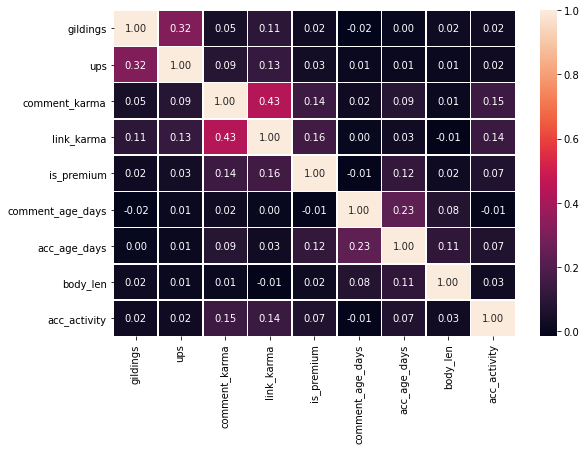

In [88]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5, ax=ax)

There's little correlation with most of the features and the target variable (gildings), so we will have to engineer more useful features (or go back to scraping and collect other useful attributes).